In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [3]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


import warnings
warnings.filterwarnings('ignore')

import gc
import time
import sys
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import preprocessing as pp
from sklearn.preprocessing import Imputer
#from sklearn.impute import SimpleImputer

from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)


from tqdm import tqdm

In [4]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }



In [5]:
%%time
nrows = 1000000
#_______________________________________________________________________________
# retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('train.csv',
                    nrows = nrows,
#                     usecols = retained_columns,
                    dtype = dtypes)


CPU times: user 24.9 s, sys: 1.3 s, total: 26.2 s
Wall time: 23.8 s


In [6]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2404.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4908.0,317701.0,4.0,5.0,1972.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,2272.0,NaN,238475.0,UNKNOWN,227116.0,0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0.17134.228,amd64,rs4_release,17134,228,P

In [7]:
target = train['HasDetections']
train.drop('HasDetections', inplace=True, axis=1)


In [8]:
num_datatypes = ['int8', 'int16', 'int32', 'float16', 'float32']
numerical_columns = [c for c,v in dtypes.items() if v in num_datatypes]

In [9]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

In [10]:
false_numerical_columns = [col for col in numerical_columns if col not in true_numerical_columns]

In [11]:
train_true_num = train[true_numerical_columns]
train_true_num.head(2)

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
0,4.0,476940.0,299451.0,4096.0,18.906250,1440.0,900.0,4.294967e+09
1,4.0,476940.0,102385.0,4096.0,13.898438,1366.0,768.0,1.000000e+00


In [12]:
train_true_num['MachineIdentifier'] = train['MachineIdentifier']

In [13]:
lgb_params = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 42,
         "verbosity": -1}


In [14]:
train_true_num.head()

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges,MachineIdentifier
0,4.0,476940.0,299451.0,4096.0,18.906250,1440.0,900.0,4.294967e+09,0000028988387b115f69f31a3bf04f09
1,4.0,476940.0,102385.0,4096.0,13.898438,1366.0,768.0,1.000000e+00,000007535c3f730efa9ea0b7ef1bd645
2,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0,4.294967e+09,000007905a28d863f6d0d597892cd692
3,4.0,238475.0,227116.0,4096.0,18.500000,1366.0,768.0,4.294967e+09,00000b11598a75ea8ba1beea8459149f
4,4.0,476940.0,101900.0,6144.0,14.000000,1366.0,768.0,0.000000e+00,000014a5f00daa18e76b81417eeb99fc


In [15]:
train_true_num.shape

(1000000, 9)

In [16]:
gc.collect()

0

In [17]:
folds = KFold(n_splits=3, shuffle=True, random_state=42)
oof = np.zeros(len(train_true_num))
# categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train_true_num.columns if c not in ['MachineIdentifier']]
# predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_true_num.values, target.values)):
    print("Fold No.{}".format(fold_+1))
    trn_data = lgb.Dataset(train_true_num.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
#                            categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train_true_num.iloc[val_idx][features],
                           label=target.iloc[val_idx],
#                            categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(lgb_params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_true_num.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("Time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])

feat_num_true_score = metrics.roc_auc_score(target, oof)
print("CV score: {:<8.5f}".format(feat_num_true_score))
print("Total time elapsed: {:<5.2}s".format(time.time() - start))

Fold No.1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.593651	valid_1's auc: 0.582075
[200]	training's auc: 0.602074	valid_1's auc: 0.581905
[300]	training's auc: 0.608531	valid_1's auc: 0.581558
Early stopping, best iteration is:
[132]	training's auc: 0.5968	valid_1's auc: 0.582179
Time elapsed: 0.0096s
Fold No.2
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.594157	valid_1's auc: 0.581507
[200]	training's auc: 0.602951	valid_1's auc: 0.581391
[300]	training's auc: 0.609878	valid_1's auc: 0.580784
Early stopping, best iteration is:
[130]	training's auc: 0.597094	valid_1's auc: 0.581699
Time elapsed: 0.02 s
Fold No.3
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.594724	valid_1's auc: 0.580661
[200]	training's auc: 0.60273	valid_1's auc: 0.580684
[300]	training's auc: 0.609445	valid_1's auc: 0.580109
Early stopping, best iteration is:
[119]	training's auc: 0.596397	

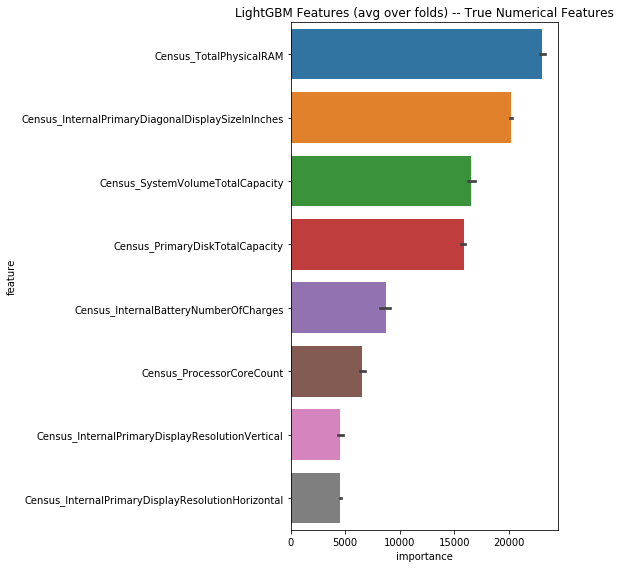

In [18]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(8,8))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds) -- True Numerical Features')
plt.tight_layout()

In [19]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = pp.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

In [20]:
train_true_num_copy = train_true_num.drop('MachineIdentifier', axis=1)

In [21]:
train_true_num_pow2 = PolynomialFeatures_labeled(train_true_num_copy.fillna(0), 2)
train_true_num_pow2.head()

,Constant Term,Census_ProcessorCoreCount^1,Census_PrimaryDiskTotalCapacity^1,Census_SystemVolumeTotalCapacity^1,Census_TotalPhysicalRAM^1,Census_InternalPrimaryDiagonalDisplaySizeInInches^1,Census_InternalPrimaryDisplayResolutionHorizontal^1,Census_InternalPrimaryDisplayResolutionVertical^1,Census_InternalBatteryNumberOfCharges^1,Census_ProcessorCoreCount^2,Census_ProcessorCoreCount^1 x Census_PrimaryDiskTotalCapacity^1,Census_ProcessorCoreCount^1 x Census_SystemVolumeTotalCapacity^1,Census_ProcessorCoreCount^1 x Census_TotalPhysicalRAM^1,Census_ProcessorCoreCount^1 x Census_InternalPrimaryDiagonalDisplaySizeInInches^1,Census_ProcessorCoreCount^1 x Census_InternalPrimaryDisplayResolutionHorizontal^1,Census_ProcessorCoreCount^1 x Census_InternalPrimaryDisplayResolutionVertical^1,Census_ProcessorCoreCount^1 x Census_InternalBatteryNumberOfCharges^1,Census_PrimaryDiskTotalCapacity^2,Census_PrimaryDiskTotalCapacity^1 x Census_SystemVolumeTotalCapacity^1,Census_PrimaryDiskTotalCapacity^1 x Census_TotalPhysicalRAM^1,Census_PrimaryDiskTotalCapacity^1 x Census_InternalPrimaryDiagonalDisplaySizeInInches^1,Census_PrimaryDiskTotalCapacity^1 x Census_InternalPrimaryDisplayResolutionHorizontal^1,Census_PrimaryDiskTotalCapacity^1 x Census_InternalPrimaryDisplayResolutionVertical^1,Census_PrimaryDiskTotalCapacity^1 x Census_InternalBatteryNumberOfCharges^1,Census_SystemVolumeTotalCapacity^2,Census_SystemVolumeTotalCapacity^1 x Census_TotalPhysicalRAM^1,Census_SystemVolumeTotalCapacity^1 x Census_InternalPrimaryDiagonalDisplaySizeInInches^1,Census_SystemVolumeTotalCapacity^1 x Census_InternalPrimaryDisplayResolutionHorizontal^1,Census_SystemVolumeTotalCapacity^1 x Census_InternalPrimaryDisplayResolutionVertical^1,Census_SystemVolumeTotalCapacity^1 x Census_InternalBatteryNumberOfCharges^1,Census_TotalPhysicalRAM^2,Census_TotalPhysicalRAM^1 x Census_InternalPrimaryDiagonalDisplaySizeInInches^1,Census_TotalPhysicalRAM^1 x Census_InternalPrimaryDisplayResolutionHorizontal^1,Census_TotalPhysicalRAM^1 x Census_InternalPrimaryDisplayResolutionVertical^1,Census_TotalPhysicalRAM^1 x Census_InternalBatteryNumberOfCharges^1,Census_InternalPrimaryDiagonalDisplaySizeInInches^2,Census_InternalPrimaryDiagonalDisplaySizeInInches^1 x Census_InternalPrimaryDisplayResolutionHorizontal^1,Census_InternalPrimaryDiagonalDisplaySizeInInches^1 x Census_InternalPrimaryDisplayResolutionVertical^1,Census_InternalPrimaryDiagonalDisplaySizeInInches^1 x Census_InternalBatteryNumberOfCharges^1,Census_InternalPrimaryDisplayResolutionHorizontal^2,Census_InternalPrimaryDisplayResolutionHorizontal^1 x Census_InternalPrimaryDisplayResolutionVertical^1,Census_InternalPrimaryDisplayResolutionHorizontal^1 x Census_InternalBatteryNumberOfCharges^1,Census_InternalPrimaryDisplayResolutionVertical^2,Census_InternalPrimaryDisplayResolutionVertical^1 x Census_InternalBatteryNumberOfCharges^1,Census_InternalBatteryNumberOfCharges^2
0,1.0,4.0,476940.0,299451.0,4096.0,18.906250,1440.0,900.0,4.294967e+09,16.0,1907760.0,1197804.0,16384.0,75.62500,5760.0,3600.0,1.717987e+10,2.274718e+11,1.428202e+11,1.953546e+09,9.017147e+06,686793600.0,429246000.0,2.048442e+15,8.967090e+10,1.226551e+09,5.661495e+06,431209440.0,269505900.0,1.286132e+15,16777216.0,77440.0,5898240.0,3686400.0,1.759219e+13,357.446289,27225.000000,17015.625,8.120173e+10,2073600.0,1296000.0,6.184753e+12,810000.0,3.865471e+12,1.844674e+19
1,1.0,4.0,476940.0,102385.0,4096.0,13.898438,1366.0,768.0,1.000000e+00,16.0,1907760.0,409540.0,16384.0,55.59375,5464.0,3072.0,4.000000e+00,2.274718e+11,4.883150e+10,1.953546e+09,6.628721e+06,651500040.0,366289920.0,4.769400e+05,1.048269e+10,4.193690e+08,1.422992e+06,139857910.0,78631680.0,1.023850e+05,16777216.0,56928.0,5595136.0,3145728.0,4.096000e+03,193.166565,18985.265625,10674.000,1.389844e+01,1865956.0,1049088.0,1.366000e+03,589824.0,7.680000e+02,1.000000e+00
2,1.0,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0,4.294967e+09,16.0,457892.0,455628.0,16384.0,86.00000,7680.0,4320.0,1.717987

In [22]:
train_true_num_pow2['MachineIdentifier'] = train_true_num['MachineIdentifier']
train_true_num_pow2.shape

(1000000, 46)

In [23]:
train_true_num_pow2 = reduce_mem_usage(train_true_num_pow2)

Mem. usage decreased to 207.85 Mb (47.3% reduction)


In [24]:
gc.collect()

2963

In [25]:
folds = KFold(n_splits=3, shuffle=True, random_state=42)
oof = np.zeros(len(train_true_num_pow2))
# categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train_true_num_pow2.columns if c not in ['MachineIdentifier']]
# predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_true_num_pow2.values, target.values)):
    print("Fold No.{}".format(fold_+1))
    trn_data = lgb.Dataset(train_true_num_pow2.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
#                            categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train_true_num_pow2.iloc[val_idx][features],
                           label=target.iloc[val_idx],
#                            categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(lgb_params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_true_num_pow2.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("Time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])

feat_num_pow2_score = metrics.roc_auc_score(target, oof)
print("CV score: {:<8.5f}".format(feat_num_pow2_score))
print("Total time elapsed: {:<5.2}s".format(time.time() - start))

Fold No.1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.598657	valid_1's auc: 0.580755
[200]	training's auc: 0.611052	valid_1's auc: 0.580609
[300]	training's auc: 0.620827	valid_1's auc: 0.579986
Early stopping, best iteration is:
[102]	training's auc: 0.598901	valid_1's auc: 0.580783
Time elapsed: 0.024s
Fold No.2
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.599108	valid_1's auc: 0.580144
[200]	training's auc: 0.611731	valid_1's auc: 0.579905
[300]	training's auc: 0.621764	valid_1's auc: 0.579052
Early stopping, best iteration is:
[120]	training's auc: 0.601861	valid_1's auc: 0.580238
Time elapsed: 0.051s
Fold No.3
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.599393	valid_1's auc: 0.579629
[200]	training's auc: 0.61169	valid_1's auc: 0.579275
[300]	training's auc: 0.621477	valid_1's auc: 0.578315
Early stopping, best iteration is:
[136]	training's auc: 0.604324

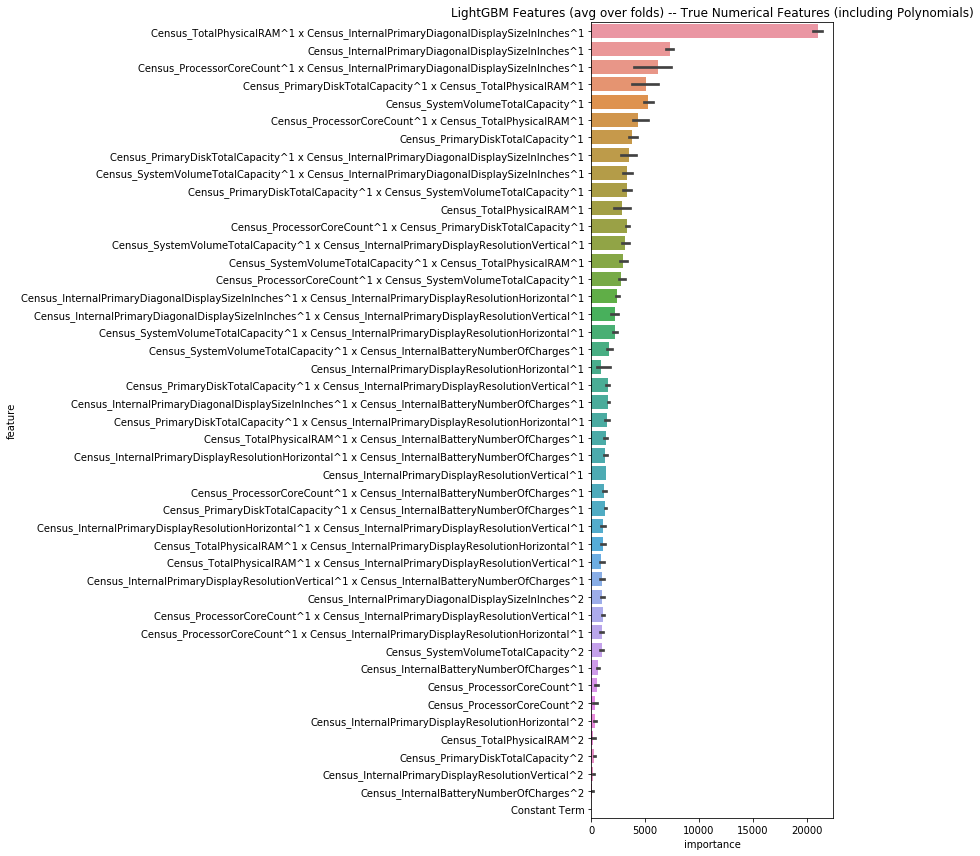

In [26]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(12,12))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds) -- True Numerical Features (including Polynomials)')
plt.tight_layout()

In [27]:
del false_numerical_columns[-1]

In [28]:
train_false_num = train[false_numerical_columns]
train_false_num['MachineIdentifier'] = train['MachineIdentifier']
train_false_num.head(2)

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,SMode,IeVerIdentifier,Firewall,UacLuaenable,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_HasOpticalDiskDrive,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_IsPortableOperatingSystem,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,MachineIdentifier
0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,17134,256,1.0,0,0.0,137.0,1.0,1.0,2668.0,9124.0,5.0,2340.0,0,17134,165,26.0,119,0,NaN,0.0,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0000028988387b115f69f31a3bf04f09
1,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,17134,256,1.0,0,0.0,137.0,1.0,1.0,2668.0,91656.0,5.0,2404.0,0,17134,1,8.0,31,0,NaN,0.0,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,000007535c3f730efa9ea0b7ef1bd645


In [29]:
train_false_num.shape

(1000000, 45)

In [30]:
train_false_num = reduce_mem_usage(train_false_num)

Mem. usage decreased to 135.37 Mb (1.4% reduction)


In [31]:
gc.collect()

0

In [32]:
folds = KFold(n_splits=3, shuffle=True, random_state=42)
oof = np.zeros(len(train_false_num))
# categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train_false_num.columns if c not in ['MachineIdentifier']]
# predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_false_num.values, target.values)):
    print("Fold No.{}".format(fold_+1))
    trn_data = lgb.Dataset(train_false_num.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
#                            categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train_false_num.iloc[val_idx][features],
                           label=target.iloc[val_idx],
#                            categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(lgb_params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_false_num.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print("Time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])

feat_num_false_score = metrics.roc_auc_score(target, oof)
print("CV score: {:<8.5f}".format(feat_num_false_score))
print("Total time elapsed: {:<5.2}s".format(time.time() - start))

Fold No.1
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.6743	valid_1's auc: 0.664654
[200]	training's auc: 0.686771	valid_1's auc: 0.667439
[300]	training's auc: 0.697012	valid_1's auc: 0.668426
[400]	training's auc: 0.70578	valid_1's auc: 0.668779
[500]	training's auc: 0.714295	valid_1's auc: 0.669329
[600]	training's auc: 0.721886	valid_1's auc: 0.669409
[700]	training's auc: 0.72906	valid_1's auc: 0.669392
Early stopping, best iteration is:
[560]	training's auc: 0.718899	valid_1's auc: 0.669475
Time elapsed: 0.07 s
Fold No.2
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.67387	valid_1's auc: 0.664241
[200]	training's auc: 0.686666	valid_1's auc: 0.666813
[300]	training's auc: 0.696867	valid_1's auc: 0.668127
[400]	training's auc: 0.705807	valid_1's auc: 0.668604
[500]	training's auc: 0.713897	valid_1's auc: 0.66885
[600]	training's auc: 0.721532	valid_1's auc: 0.668988
[700]	training's auc: 0.728658	val

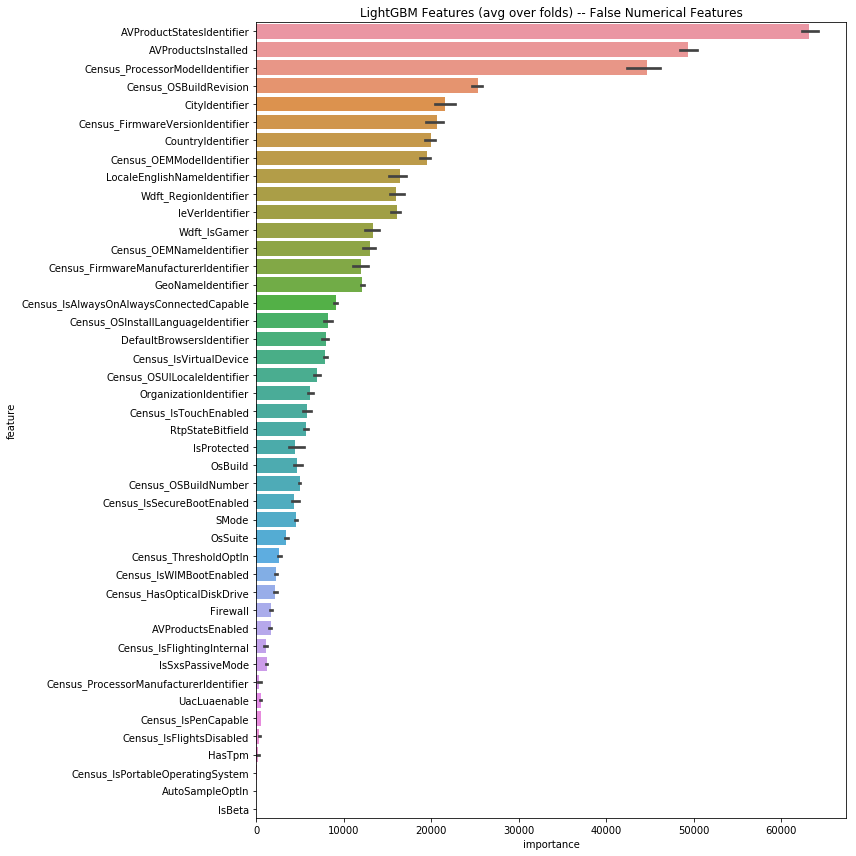

In [33]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(12,12))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds) -- False Numerical Features')
plt.tight_layout()